https://medium.com/towards-artificial-intelligence/text-classification-by-xgboost-others-a-case-study-using-bbc-news-articles-5d88e94a9f8

In [1]:
import pandas as pd

bbc_text_df = pd.read_csv('data/bbc-text.csv')
bbc_text_df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


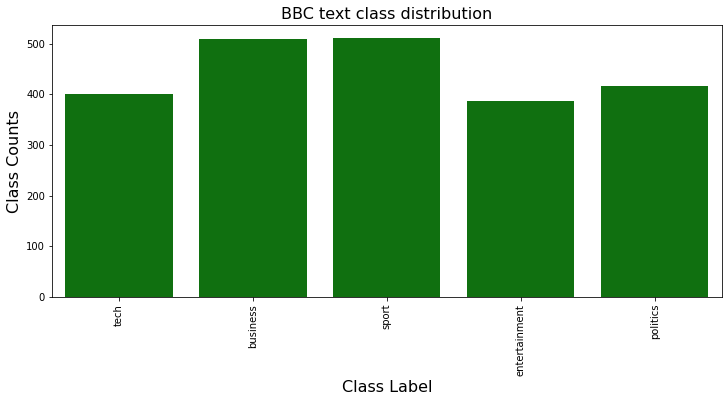

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.countplot(x=bbc_text_df.category, color='green')
plt.title('BBC text class distribution', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

In [3]:
# !pip install gensim

In [4]:
# !pip freeze > requierments.txt

In [5]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [6]:
bbc_text_df.iloc[2,1]

'tigers wary of farrell  gamble  leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes.   we and anybody else involved in the process are still some way away from going to the next stage   tigers boss john wells told bbc radio leicester.  at the moment  there are still a lot of unknowns about andy farrell  not least his medical situation.  whoever does take him on is going to take a big  big gamble.  farrell  who has had persistent knee problems  had an operation on his knee five weeks ago and is expected to be out for another three months. leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game.  if he does move across to union  wells believes he would better off playing in the backs  at least initially.  i m sure he could make the step between league and union by being involved in the centre   said wells.  i t

In [7]:
clean_text(bbc_text_df.iloc[2,1])

'tiger wari farrel gambl leicest rush make bid andi farrel great britain rugbi leagu captain decid switch code anybodi involv process wai awai go stage tiger boss john well told bbc radio leicest moment lot unknown andi farrel medic situat go big big gambl farrel persist knee problem oper knee week ago expect month leicest saracen believ head list rugbi union club interest sign farrel decid man game union well believ better plai back initi sure step leagu union involv centr said well think england prefer progress posit row us rugbi leagu skill forward juri cross divid club balanc struck cost gambl option bring readi replac'

In [8]:
# !pip install wordcloud

In [9]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

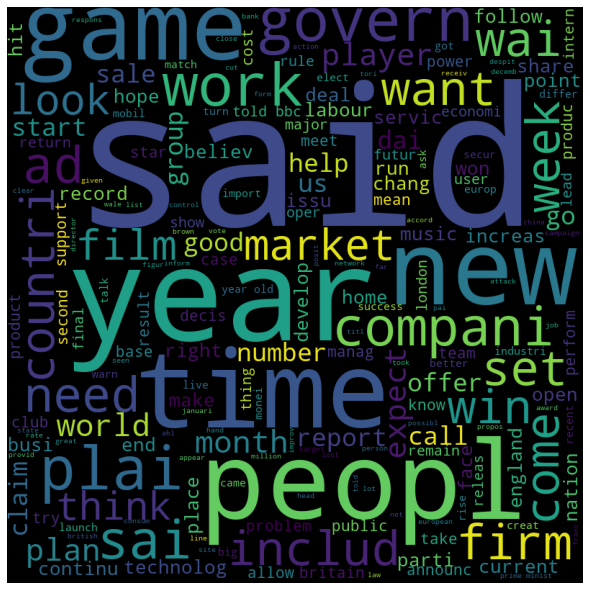

In [10]:
texts = ''
for index, item in bbc_text_df.iterrows():
    texts = texts + ' ' + clean_text(item['text'])
    
plot_word_cloud(texts)


In [11]:
def plot_word_cloud_for_category(bbc_text_df, category):
    text_df = bbc_text_df.loc[bbc_text_df['category'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + clean_text(item['text'])
    
    plot_word_cloud(texts)

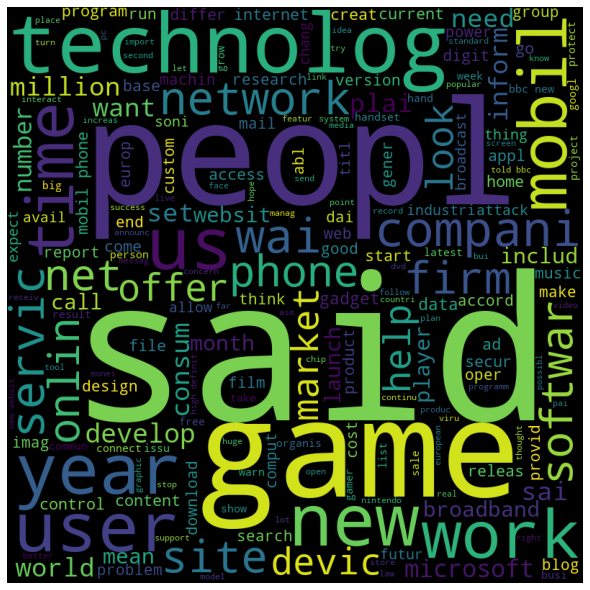

In [12]:
plot_word_cloud_for_category(bbc_text_df,'tech')

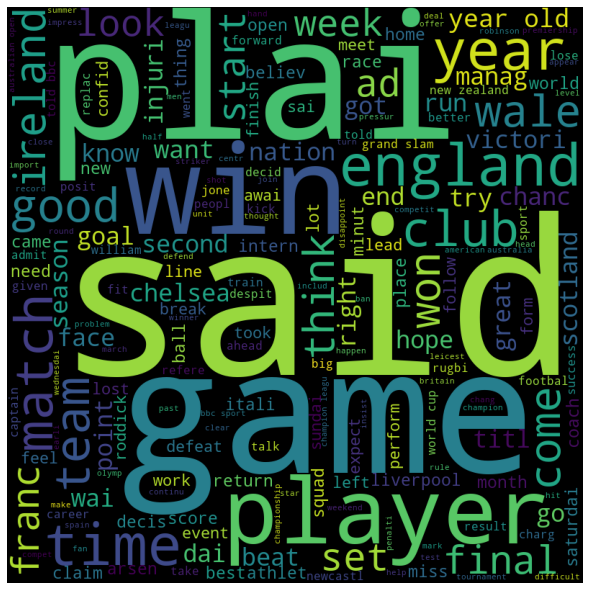

In [13]:
plot_word_cloud_for_category(bbc_text_df,'sport')

In [14]:
df_x = bbc_text_df['text']
df_y = bbc_text_df['category']

In [15]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))


In [16]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)
doc2vec_features

100%|██████████| 2225/2225 [00:00<00:00, 1941807.41it/s]


matrix([[ 1.0151277e-01, -4.6181083e-02, -1.5727669e-01, ...,
         -1.7375520e-01, -1.5367087e-02, -6.9150068e-03],
        [ 9.7357392e-02, -2.3479687e-02, -1.5281729e-01, ...,
         -1.4655399e-01,  8.5931653e-03, -1.1011532e-02],
        [-6.1006744e-05,  4.8988047e-03,  3.8928762e-03, ...,
          5.2841561e-04, -6.5440073e-04,  1.4149434e-03],
        ...,
        [-1.8478017e-02,  7.3533612e-03,  3.0495230e-02, ...,
          3.0245239e-02,  4.3676090e-03, -2.0174608e-03],
        [ 2.4971685e-01, -4.7996394e-02, -3.7614304e-01, ...,
         -4.2183876e-01,  7.5304510e-05, -6.9918156e-02],
        [ 1.0729397e-03,  8.2526257e-04, -1.6623673e-03, ...,
         -2.4616209e-04,  3.9097741e-03,  1.2121628e-03]], dtype=float32)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

100%|██████████| 1780/1780 [00:00<00:00, 3083792.28it/s]
/home/jeremy/gitlab/CodeSnips/codesnips/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 1780/1780 [00:00<00:00, 2373128.14it/s]
/home/jeremy/gitlab/CodeSnips/codesnips/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 1780/1780 [00:00<00:00, 1950329.45it/s]
/home/jeremy/gitlab/CodeSnips/codesnips/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for Logistic Regression:  0.3698876404494382


In [18]:
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

100%|██████████| 1780/1780 [00:00<00:00, 1925183.37it/s]


Accuracy for XGBoost Classifier :  0.3564044943820225


In [23]:
from sklearn.ensemble import RandomForestClassifier

pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

100%|██████████| 1780/1780 [00:00<00:00, 1641209.30it/s]


Accuracy for RandomForest :  0.3631460674157304


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [25]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)


In [26]:
pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

/home/jeremy/gitlab/CodeSnips/codesnips/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jeremy/gitlab/CodeSnips/codesnips/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jeremy/gitlab/CodeSnips/codesnips/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jeremy/gitlab/CodeSnips/codesnips/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for Tf-Idf & Logistic Regression:  0.8966292134831461


In [27]:
pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

Accuracy for Tf-Idf & RandomForest :  0.9424719101123596


In [28]:
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())

Accuracy for Tf-Idf & XGBoost Classifier :  0.9330337078651686
